%matplotlib widget# Using observatory data as Remote Reference

This is an example notebook for processing broadband data with an observatory as a remote reference. 

In [1]:
%matplotlib widget

## Download Geomagnetic Observatory Data

Download data from the USGS Geomagnetic data center for the full time of the survey.  First make a request dataframe.

In [1]:
import pandas as pd

from mth5.clients import MakeMTH5



2023-04-14 15:31:38,243 [line 135] mth5.setup_logger - INFO: Logging file can be found C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\logs\mth5_debug.log


In [2]:
request_df = pd.DataFrame(
    {
        "observatory": ["frn"],
        "type": ["adjusted"],
        "elements": [["x", "y"]],
        "sampling_period": [1],
        "start": ["2021-04-05T00:00:00"],
        "end": ["2021-04-16T00:00:00"],
    }
)

In [3]:
%%time
make_mth5_object = MakeMTH5(
    mth5_version="0.2.0",
    interact=False,
    save_path=r"c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021",
)
mth5_filename = make_mth5_object.from_usgs_geomag(request_df)

2023-04-14 14:54:48,256 [line 286] mth5.groups.base.MasterSurvey.add_survey - INFO: survey USGS-GEOMAG already exists, returning existing group.
2023-04-14 14:55:33,415 [line 678] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2021-04-16T00:00:05+00:00 does not match metadata end 2021-04-16T00:00:00+00:00 updating metatdata value to 2021-04-16T00:00:05+00:00
2023-04-14 14:55:33,496 [line 313] mth5.groups.base.MasterStation.add_station - INFO: Station Fresno already exists, returning existing group.
2023-04-14 14:55:33,593 [line 761] mth5.groups.base.Station.add_run - INFO: run sp1_001 already exists, returning existing group.
2023-04-14 14:55:35,089 [line 755] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\usgs_geomag_frn_xy.h5
2023-04-14 14:55:35,094 [line 325] mth5.mth5.MTH5.filename - WARNING: MTH5 file is not open or has not been created yet. Returning default name


Wall time: 46.9 s


## Combine Runs with sample rate of 1 second

Now we need to combine runs of various sample rates into a single run with the sample rate of 1 second.

read into channels, create a run, use reindex.

In [2]:
from matplotlib import pyplot as plt

from mth5 import read_file
from mth5.io.zen import Z3DCollection
from mth5.mth5 import MTH5

2023-04-17 15:13:13,583 [line 135] mth5.setup_logger - INFO: Logging file can be found C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\logs\mth5_debug.log


In [3]:
zc = Z3DCollection(r"c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\gz316")
runs = zc.get_runs(sample_rates=[4096, 256])

In [4]:
runs["gz316"]["sr256_0003"]

,survey,station,run,start,end,channel_id,component,fn,sample_rate,file_size,n_samples,sequence_number,instrument_id,coil_number,calibration_fn
4,geysers01,gz316,sr256_0003,2021-04-10 01:09:58+00:00,2021-04-10 07:21:45.683594+00:00,2,hy,c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021...,256.0,22842556,5710767,3,ZEN_026,2344,None
5,geysers01,gz316,sr256_0003,2021-04-10 01:09:58+00:00,2021-04-10 07:21:45.683594+00:00,1,hx,c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021...,256.0,22843068,5710767,3,ZEN_026,2304,None
6,geysers01,gz316,sr256_0003,2021-04-10 01:09:58+00:00,2021-04-10 07:21:45.683594+00:00,5,ey,c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021...,256.0,22839996,5710767,3,ZEN_026,316,None
7,geysers01,gz316,sr256_0003,2021-04-10 01:09:58+00:00,2021-04-10 07:21:45.687500+00:00,4,ex,c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021...,256.0,22840000,5710768,3,ZEN_026,341,None


In [5]:
calibrate = False
m = MTH5()
if calibrate:
    m.data_level = 2
m.open_mth5(zc.file_path.joinpath("gz316_with_1s_data_coil_fn.h5"))

2023-04-17 15:13:21,547 [line 674] mth5.mth5.MTH5._initialize_file - INFO: Initialized MTH5 0.2.0 file c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\gz316\gz316_with_1s_data_coil_fn.h5 in mode a


In [6]:
%%time
survey_group = m.add_survey("geysers01")
for station_id in runs.keys():
    station_group = survey_group.stations_group.add_station(station_id)
    station_group.metadata.update(zc.station_metadata_dict[station_id])
    station_group.write_metadata()
    run_list = []
    for run_id, run_df in runs[station_id].items():
        run_group = station_group.add_run(run_id)
        for row in run_df.itertuples():
            ch_ts = read_file(
                row.fn,
                calibration_fn=r"c:\Users\jpeacock\OneDrive - DOI\MTData\amtant.cal",
            )
            # NOTE: this is where the calibration occurs
            if calibrate:
                ch_ts = ch_ts.remove_instrument_response()
            run_group.from_channel_ts(ch_ts)
        run_group.update_run_metadata()
        run_list.append(run_group.to_runts())

    combined_run = run_list[0].merge(run_list[1:], new_sample_rate=1)
    combined_run.run_metadata.id = "sr1_0001"
    combined_run_group = station_group.add_run("sr1_0001")
    combined_run_group.from_runts(combined_run)
    combined_run_group.update_run_metadata()

    station_group.update_station_metadata()

survey_group.update_survey_metadata()

2023-04-17 15:13:29,477 [line 358] mth5.timeseries.run_ts.RunTS._align_channels - INFO: Channels do not have a common end, using latest: 2021-04-10T01:09:43.998779296
2023-04-17 15:13:31,248 [line 678] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2021-04-10T01:09:43.998535156+00:00 does not match metadata end 2021-04-10T01:09:43.998779296+00:00 updating metatdata value to 2021-04-10T01:09:43.998535156+00:00
2023-04-17 15:13:37,256 [line 358] mth5.timeseries.run_ts.RunTS._align_channels - INFO: Channels do not have a common end, using latest: 2021-04-10T06:59:43.996094000
2023-04-17 15:13:43,570 [line 358] mth5.timeseries.run_ts.RunTS._align_channels - INFO: Channels do not have a common end, using latest: 2021-04-10T07:09:43.998535156
2023-04-17 15:13:45,480 [line 678] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2021-04-10T07:09:43.998291015+00:00 does not match metadata end 2021-04-10T07:09:43.998535156+00:00 updating 

Wall time: 55 s


In [7]:
m.close_mth5()

2023-04-17 15:14:27,306 [line 755] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\gz316\gz316_with_1s_data_coil_fn.h5


In [8]:
combined_run

RunTS Summary:
	Survey:      geysers01
	Station:     gz316
	Run:         sr1_0001
	Start:       2021-04-09T23:24:59+00:00
	End:         2021-04-10T17:09:41+00:00
	Sample Rate: 1.0
	Components:  ['ex', 'ey', 'hx', 'hy']

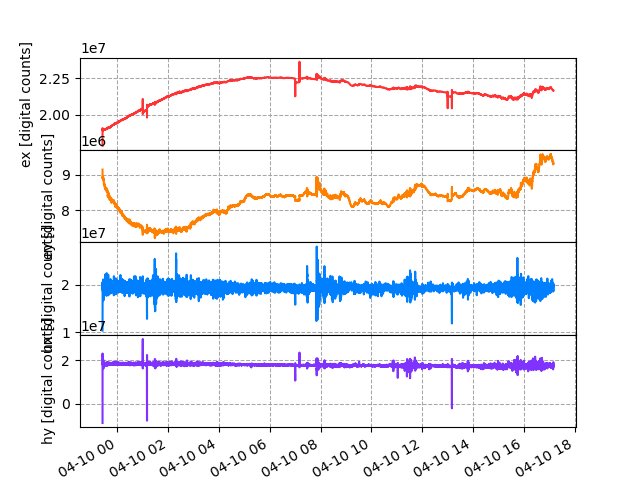

In [9]:
combined_run.plot()

In [29]:
c = combined_run.calibrate(bandpass={"low": 1e-4, "high": 0.45, "order": 1})

2023-04-17 15:17:58,008 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-17 15:17:58,401 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution


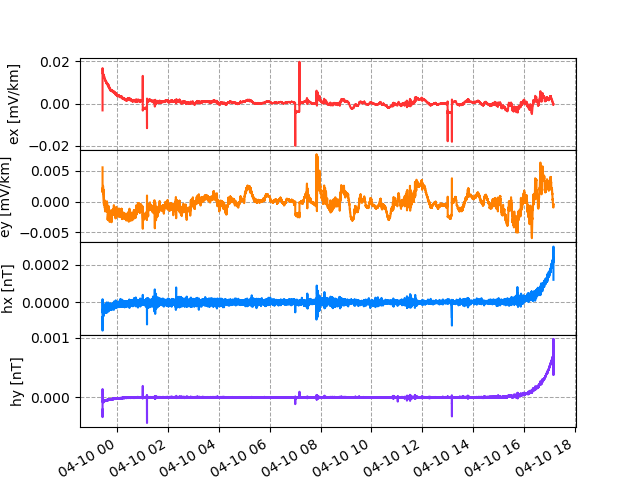

In [30]:
c.plot()

In [11]:
m_obs = MTH5()
m_obs.open_mth5(r"c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\usgs_geomag_frn_xy.h5")

In [12]:
r_obs = m_obs.get_run("Fresno", "sp1_001", "USGS-GEOMAG")

In [13]:
r_obs_slice = r_obs.to_runts(start=combined_run.start, end=combined_run.end)

2023-04-14 15:52:51,097 [line 664] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: start time of dataset 2021-04-09T23:24:59+00:00 does not match metadata start 2021-04-05T00:00:00+00:00 updating metatdata value to 2021-04-09T23:24:59+00:00
2023-04-14 15:52:51,103 [line 678] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2021-04-10T17:09:41+00:00 does not match metadata end 2021-04-16T00:00:05+00:00 updating metatdata value to 2021-04-10T17:09:41+00:00


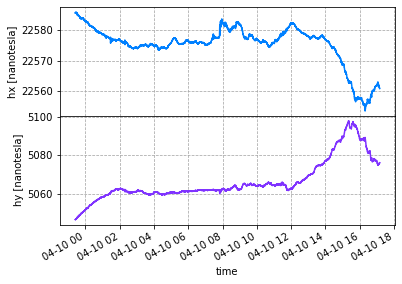

In [14]:
r_obs_slice.plot()

In [15]:
m_obs.close_mth5()

2023-04-14 15:52:51,705 [line 755] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\usgs_geomag_frn_xy.h5


## Process With Aurora

In [1]:
# Required imports for the program.
import warnings
from pathlib import Path

from aurora.config.config_creator import ConfigCreator
from aurora.pipelines.process_mth5 import process_mth5
from aurora.pipelines.run_summary import RunSummary
from aurora.transfer_function.kernel_dataset import KernelDataset

warnings.filterwarnings("ignore")

2023-04-17 15:47:44,067 [line 135] mth5.setup_logger - INFO: Logging file can be found C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\mth5\logs\mth5_debug.log


In [2]:
station_path = Path(
    r"c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\gz316\gz316_with_1s_data_coil_fn.h5"
)
obs_path = Path(r"c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\usgs_geomag_frn_xy.h5")

In [3]:
mth5_run_summary = RunSummary()
mth5_run_summary.from_mth5s([station_path, obs_path])
run_summary = mth5_run_summary.clone()
run_summary.add_duration()
run_summary.df = run_summary.df[run_summary.df.sample_rate == 4096].iloc[0:1]
run_summary.mini_summary

2023-04-17 15:47:48,422 [line 755] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\gz316\gz316_with_1s_data_coil_fn.h5
2023-04-17 15:47:48,480 [line 755] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\usgs_geomag_frn_xy.h5


,survey,station_id,run_id,start,end
2,geysers01,gz316,sr4096_0002,2021-04-10 00:59:59+00:00,2021-04-10 01:09:43.997314453+00:00


In [4]:
kernel_dataset = KernelDataset()
kernel_dataset.from_run_summary(run_summary, "gz316")#, "Fresno")
mimimum_run_duration = 100  # seconds
kernel_dataset.drop_runs_shorter_than(mimimum_run_duration)
kernel_dataset.mini_summary

,survey,station_id,run_id,start,end,duration
0,geysers01,gz316,sr4096_0002,2021-04-10 00:59:59+00:00,2021-04-10 01:09:43.997314453+00:00,584.997314


In [5]:
cc = ConfigCreator()
config = cc.create_from_kernel_dataset(kernel_dataset)
for decimation in config.decimations:
    decimation.estimator.engine = "RME"
    decimation.window.type = "hamming"
    decimation.output_channels = ["ex", "ey"]

Bands not defined; setting to EMTF BANDS_DEFAULT_FILE
C:\Users\jpeacock\OneDrive - DOI\Documents\GitHub\aurora\aurora\config\emtf_band_setup\bs_test.cfg


('geysers01', 'gz316', 'sr4096_0002', Timestamp('2021-04-10 00:59:59+0000', tz='UTC'))
      survey station_id       run_id                     start  \
0  geysers01      gz316  sr4096_0002 2021-04-10 00:59:59+00:00   
1  geysers01      gz316  sr4096_0002 2021-04-10 00:59:59+00:00   
2  geysers01      gz316  sr4096_0002 2021-04-10 00:59:59+00:00   
3  geysers01      gz316  sr4096_0002 2021-04-10 00:59:59+00:00   

                                  end input_channels output_channels  \
0 2021-04-10 01:09:43.997314453+00:00       [hx, hy]        [ex, ey]   
1 2021-04-10 01:09:43.997314453+00:00       [hx, hy]        [ex, ey]   
2 2021-04-10 01:09:43.997314453+00:00       [hx, hy]        [ex, ey]   
3 2021-04-10 01:09:43.997314453+00:00       [hx, hy]        [ex, ey]   

                          channel_scale_factors  \
0  {'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0}   
1  {'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0}   
2  {'ex': 1.0, 'ey': 1.0, 'hx': 1.0, 'hy': 1.0}   
3  {'ex': 1.0, 'e

2023-04-17 15:47:56,906 [line 678] mth5.timeseries.run_ts.RunTS.validate_metadata - WARNING: end time of dataset 2021-04-10T01:09:43.997070312+00:00 does not match metadata end 2021-04-10T01:09:43.998779296+00:00 updating metatdata value to 2021-04-10T01:09:43.997070312+00:00


DATASET DF POPULATED
Processing config indicates 4 decimation levels 
After validation there are 4 valid decimation levels
DATASET DF UPDATED


2023-04-17 15:47:59,316 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-17 15:47:59,365 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution


Processing band 0.006281s
Processing band 0.004866s
Processing band 0.003702s
Processing band 0.002868s
Processing band 0.002245s
Processing band 0.001797s
Processing band 0.001430s
Processing band 0.001143s


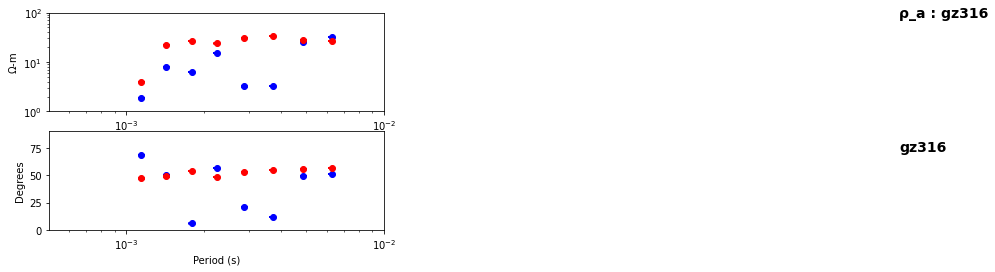

DECIMATION LEVEL 1
DATASET DF UPDATED


2023-04-17 15:48:23,139 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-17 15:48:23,193 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution


Processing band 0.025126s
Processing band 0.020906s
Processing band 0.016817s
Processing band 0.013231s
Processing band 0.010499s
Processing band 0.008133s


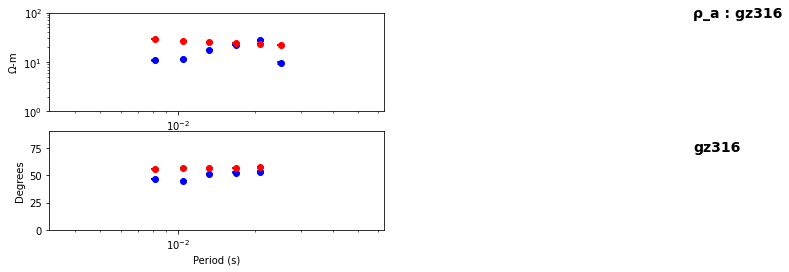

DECIMATION LEVEL 2
DATASET DF UPDATED


2023-04-17 15:48:28,591 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-17 15:48:28,645 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution


Processing band 0.100504s
Processing band 0.083624s
Processing band 0.067267s
Processing band 0.052926s
Processing band 0.041996s
Processing band 0.032530s


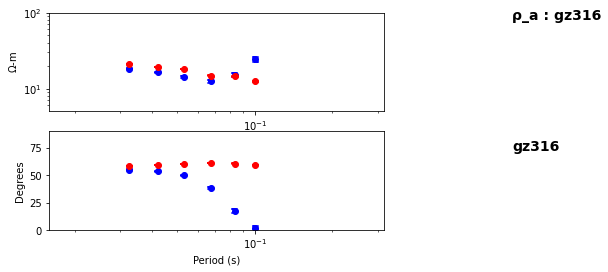

DECIMATION LEVEL 3
DATASET DF UPDATED


2023-04-17 15:48:31,078 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution
2023-04-17 15:48:31,126 [line 222] mt_metadata.base.metadata.frequency_response_table_filter.complex_response - WARNING: Extrapolating, use values outside calibration frequencies with caution


Processing band 0.369800s
Processing band 0.254514s
Processing band 0.176604s
Processing band 0.130120s
Processing band 0.100791s


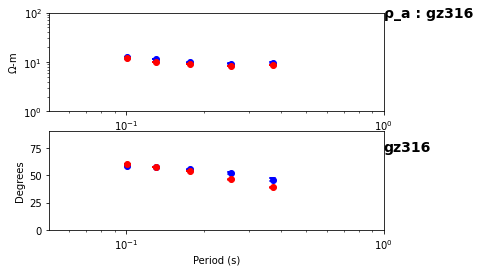

2023-04-17 15:48:35,170 [line 755] mth5.mth5.MTH5.close_mth5 - INFO: Flushing and closing c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\gz316\gz316_with_1s_data_coil_fn.h5


=== FINISHED ===
Wall time: 39.5 s


In [6]:
%%time
tf_cls = process_mth5(
    config,
    kernel_dataset,
    units="MT",
    show_plot=True,
    z_file_path=None,
)
print("=== FINISHED ===")

In [7]:
edi = tf_cls.write_tf_file(station_path.parent.joinpath("gz316_4096.edi"))

2023-04-17 15:48:46,636 [line 330] mt_metadata.base.metadata.define_measurement.write_measurement - INFO: No XMEAS information.
2023-04-17 15:48:46,645 [line 215] mt_metadata.transfer_functions.io.readwrite.write_file - INFO: Wrote c:\Users\jpeacock\OneDrive - DOI\MTData\GZ2021\gz316\gz316_4096.edi


## Use MTpy to plot

In [8]:
from mtpy import MT

In [9]:
mt_obj = MT()
mt_obj.read_tf_file(edi.fn)

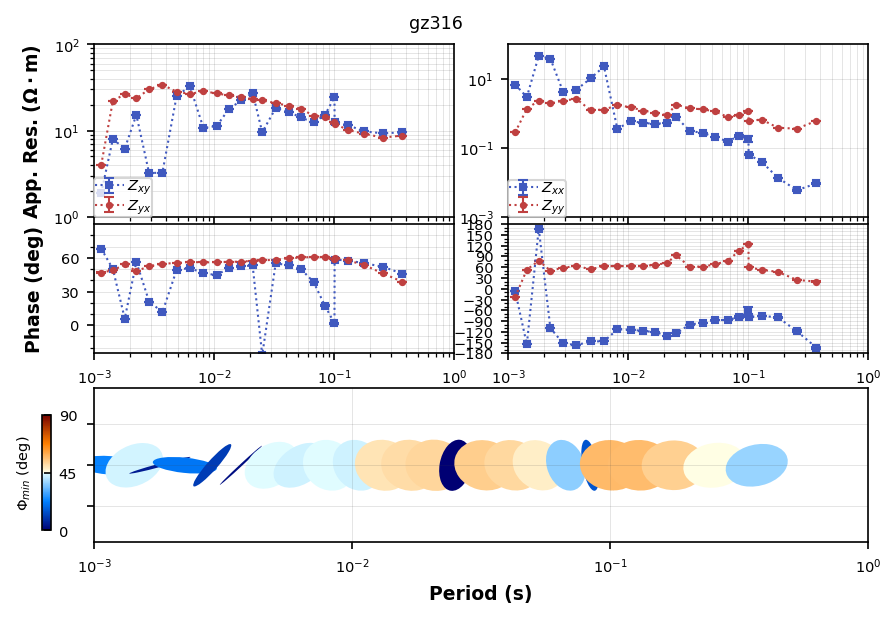

In [10]:
p1 = mt_obj.plot_mt_response(fig_num=5, plot_num=2)

In [79]:
m = MTH5()
m.open_mth5(zc.file_path.joinpath("gz316_with_1s_data_05.h5"))

In [80]:
hx = m.get_channel("gz316", "sr256_0001", "hx", "geysers01")

In [82]:
hx.channel_response_filter

Filters Included:
frequency_response_table_filter:
	amplitudes = [ 0.17656  0.28084  0.39696  0.4012   0.6018   0.76228  1.16348  1.45762
  1.56468  2.36708  3.12935  3.36917  4.69403  6.25871  9.27096 11.1192
 12.3912  18.5685  24.2477  25.9229  35.1808  44.645   60.1221  67.3102
 70.6181  83.1878  89.2429  90.0502  94.4927  96.8533  98.3269  98.9404
 98.9429  99.3454  99.3539  99.5506  99.5922  99.5952  99.6053  99.6192
 99.6507  99.6549  99.7073  99.7304  99.7383  99.7555  99.8126  99.8565 ]
	calibration_date = 1980-01-01
	comments = induction coil response read from z3d file
	frequencies = [1.16568582e-04 1.55424829e-04 2.33136527e-04 3.10850294e-04
 4.66274645e-04 6.21698996e-04 9.32549290e-04 1.24339799e-03
 1.86510495e-03 2.48679599e-03 3.73019398e-03 4.97359197e-03
 7.46038796e-03 9.94718394e-03 1.49207759e-02 1.98943679e-02
 2.98415518e-02 3.97887358e-02 5.96831037e-02 7.95774715e-02
 1.19366207e-01 1.59154943e-01 2.38732415e-01 3.18309886e-01
 4.77464829e-01 6.36619772e-01 9.